# Task 1: A/B Testing

### 1.1 problem statement

One of the primary tasks for an analyst on our team is to conduct experiments correctly. For this, we use the A/B testing method. During the testing of one hypothesis, the target group was offered a new payment mechanism on the website, while the control group continued with the basic payment mechanism. Your task is to analyze the experiment results and conclude whether the new payment mechanism should be rolled out to all users.

### 1.2 input data

• **groups.csv** - a file with information about user assignment to the control or experimental group (A - control group, B - target group).

• **groups_add.csv** - an additional file with users that was sent to you two days after the initial handover.

• **active_studs.csv** - a file with information about users who visited the platform during the experiment days.

• **checks.csv**- a file with information about user payments during the experiment days.

In [2]:
import pandas as pd
import requests
import json
from urllib.parse import urlencode
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize': (16, 5)})
colors = ["#69b3a2", "#4374B3"]
sns.set_palette(sns.color_palette(colors))
import numpy as np
import scipy.stats as ss
from tqdm.auto import tqdm
import pingouin as pg


## 1. performing EDA
---
**read the data using the API and function**

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
sep = ';'

def read_data_from_url(base_url: str, url: str, sep: str) -> pd.DataFrame:
    final_url = base_url + urlencode(dict(public_key= url))
    res_df = pd.read_csv(requests.get(final_url).json()['href'], sep= sep)
    return res_df

groups = read_data_from_url(base_url=base_url, url=groups_url, sep= sep)
groups_add = read_data_from_url(base_url=base_url, url=groups_add_url, sep= ',')
active_studs = read_data_from_url(base_url=base_url, url=active_studs_url, sep= sep)
checks = read_data_from_url(base_url=base_url, url=checks_url, sep= sep)

**1.1 groups.csv** - a file with information about user assignment to the control or experimental group (A - control group, B - target group).

In [3]:
groups.head(5)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

(74484, 2)

In [5]:
groups.groupby(['grp']).id.count()

grp
A    14671
B    59813
Name: id, dtype: int64

In [6]:
groups.dtypes

id      int64
grp    object
dtype: object

In [7]:
groups.nunique()

id     74484
grp        2
dtype: int64

the data is clean and of the correct type. there is a significant difference between the distribution of users in the test group B and the control group A.

**1.2. groups_add.csv** - an additional file with users that was sent to you two days after the initial handover.

In [8]:
groups_add.head(5)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [10]:
groups_add.shape

(92, 2)

In [11]:
groups_add.nunique()

id     92
grp     2
dtype: int64

In [12]:
groups_add.groupby(['grp']).id.count()

grp
A    22
B    70
Name: id, dtype: int64

combine the users into a single dataframe.

In [13]:
all_students = pd.concat([groups, groups_add], ignore_index= True) 

In [14]:
all_students.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [15]:
all_students.shape

(74576, 2)

check if the data has been combined correctly

In [16]:
74484+92

74576

In [17]:
all_students.isna().sum()

id     0
grp    0
dtype: int64

**1.3 active_studs.csv** - a file with information about users who visited the platform during the experiment days.

In [18]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [19]:
active_studs.dtypes

student_id    int64
dtype: object

In [20]:
active_studs.shape

(8341, 1)

In [21]:
active_studs.nunique()

student_id    8341
dtype: int64

rename student_id to id for a consistent style and correct merging

In [22]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [23]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


add a column to indicate active users during the experiment days with a value of 1, merge it with the previous df, and replace NaN values with 0 (for users who were not active during the experiment period).

In [24]:
active_studs.insert(loc=1, column='active_student', value=1)

In [25]:
all_students_up = all_students.merge(active_studs, how='outer', on='id')

In [26]:
all_students_up['active_student'] = all_students_up['active_student'].fillna(0) 

In [27]:
all_students_up.head()

,id,grp,active_student
0,1489,B,0.0
1,1627,A,1.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0


check if the data has been combined correctly

In [28]:
all_students_up.id.nunique()

74576

In [29]:
all_students_up.groupby(['grp','active_student']).id.count()

grp  active_student
A    0.0               13155
     1.0                1538
B    0.0               53080
     1.0                6803
Name: id, dtype: int64

**1.4 checks.csv**- a file with information about user payments during the experiment days

In [30]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [31]:
checks.shape

(541, 2)

In [32]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [33]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

rename the student_id column and merge it with the main table

In [34]:
checks = checks.rename(columns={'student_id': 'id'})

In [35]:
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [36]:
all_students_fin = all_students_up.merge(checks, how='outer', on='id')

In [37]:
all_students_fin.head()

,id,grp,active_student,rev
0,1489,B,0.0,NaN
1,1627,A,1.0,990.0
2,1768,B,0.0,NaN
3,1783,B,0.0,NaN
4,1794,A,0.0,NaN


In [38]:
all_students_fin['rev'] = all_students_fin['rev'].fillna(0) 

In [39]:
all_students_fin.head()

,id,grp,active_student,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [40]:
all_students_fin.isna().sum()

id                0
grp               0
active_student    0
rev               0
dtype: int64

examine the final table, which includes all users with information on purchases and activity during the experiment period

In [41]:
all_students_fin

,id,grp,active_student,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74571,200247820,B,0.0,0.0
74572,201032527,B,0.0,0.0
74573,201067612,B,0.0,0.0
74574,201067653,B,0.0,0.0


In [42]:
all_students_fin.groupby(['active_student']).rev.count()

active_student
0.0    66235
1.0     8341
Name: rev, dtype: int64

In [66]:
all_students_fin.query('active_student == 0 and rev!= 0').shape[0]

149

users who were not active on the platform during the experiment period but made payments have been identified. this may be due to data errors or automatic payments, but we will not include these users in further analysis.

examine the active users who were on the platform during the experiment period

In [44]:
active_student = all_students_fin.query ('active_student == 1')

In [45]:
active_student.nunique()

id                8341
grp                  2
active_student       1
rev                 39
dtype: int64

## 2. Examine the data distribution using graphs.
___

**2.1 Examine how payments are distributed among active users**

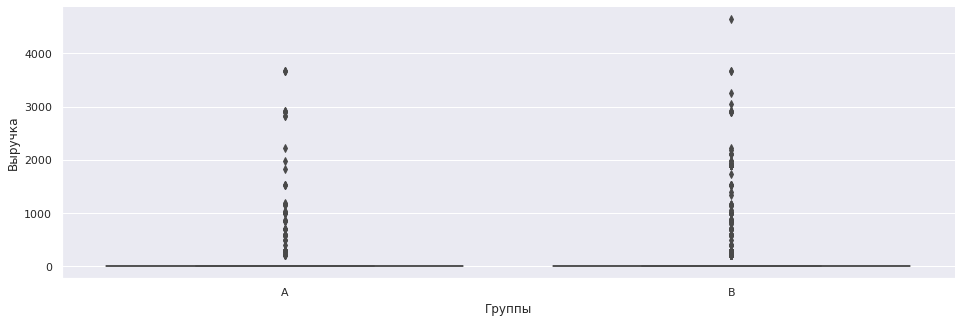

In [46]:
ax = sns.boxplot(x='grp', y='rev', data = active_student)
ax.set(xlabel='Группы', ylabel='Выручка')
sns.despine()

a large portion of the active audience in both groups did not make purchases (revenue value is 0)

**2.2 Examine the active users who made purchases in both groups and how the values are distributed.**

In [55]:
students_rev = active_student.query('rev != 0')

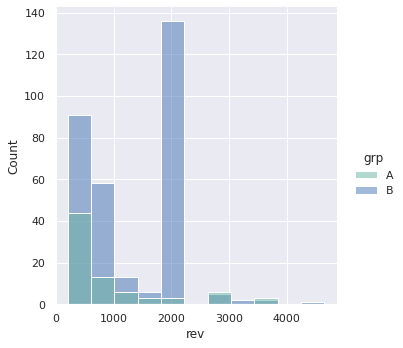

In [57]:
sns.displot(x= 'rev', data= students_rev, hue= 'grp')

The distribution of payments differs between the two groups. It can be assumed that this is because the sample size in group B is nearly four times larger than in group A, which may result in a wider spread of values, or that the sample in group B is more representative.

In [61]:
stat_describe_stud_rev = students_rev.groupby('grp').rev.describe().reset_index()
stat_describe_stud_rev

,grp,count,mean,std,min,25%,50%,75%,max
0,A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
1,B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


**2.3 Examine the distribution of the number of students who made a purchase in both groups, broken down by price**

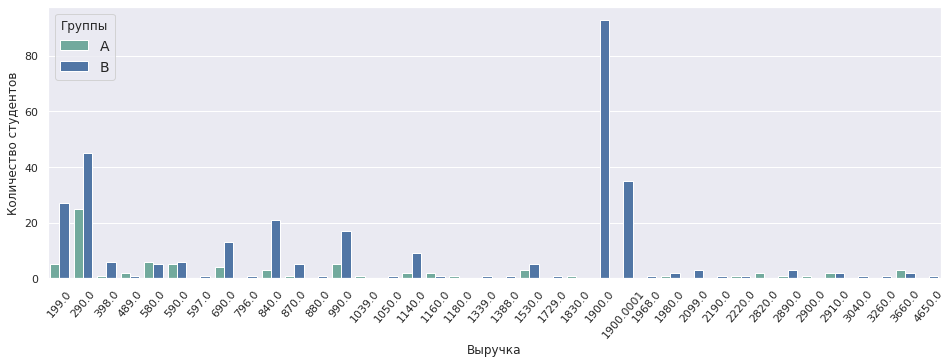

In [56]:
ax = sns.countplot(data= students_rev, x='rev', hue='grp')
ax.set(xlabel='Выручка', ylabel='Количество студентов')
ax.legend(fontsize=14, title='Группы')
plt.xticks(rotation=50)
plt.show()

The spikes in purchases in the test group B in the 1900 RUB range suggest that the new payment mechanism may have improved sales. However, we must also consider that the test group B is four times larger than the control group A.

In [59]:
stat_describe_active_student = active_student.groupby('grp').rev.describe().reset_index()
stat_describe_active_student

,grp,count,mean,std,min,25%,50%,75%,max
0,A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
1,B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


## 3. Selecting metrics and conducting tests
___

We will define a set of metrics that can be applied to our study to decide whether to implement the new payment mechanism:

1. **CR (Conversion Rate)**: CR = number of customers / number of users.
2. **ARPU (Average Revenue Per User)**: ARPU = revenue / number of users.
3. **Average Order Value**: total amount of all orders / number of customers.

Let's calculate the metrics:

In [49]:
a_gr_plat = active_student.query('grp == "A"')
b_gr_plat = active_student.query('grp == "B"')

In [50]:
cr_a_gr = (a_gr_plat[a_gr_plat.rev != 0].rev.count() / a_gr_plat.rev.count() * 100).round(2)
cr_b_gr = (b_gr_plat[b_gr_plat.rev != 0].rev.count() / b_gr_plat.rev.count() * 100).round(2)
arpu_a = (a_gr_plat.rev.sum() / a_gr_plat.id.nunique()).round(2)
arpu_b = (b_gr_plat.rev.sum() / b_gr_plat.id.nunique()).round(2)
mean_rev_a = a_gr_plat.query('rev!=0').rev.mean().round(2)
mean_rev_b = b_gr_plat.query('rev!=0').rev.mean().round(2)

Create a dataframe with all the metrics:

In [52]:
df = pd.DataFrame({'group': ['A', 'B'],
                   'count_students': [stat_describe_active_student['count'][0],
                                      stat_describe_active_student['count'][1]],
                   'count_clients': [stat_describe_stud_rev['count'][0],
                                     stat_describe_stud_rev['count'][1]],
                   'CR%': [cr_a_gr, cr_b_gr],
                   'ARPU': [arpu_a, arpu_b],
                   'mean_rev': [mean_rev_a, mean_rev_b]})
df

,group,count_students,count_clients,CR%,ARPU,mean_rev
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


### Calculating CR
The best method to test the statistical significance for proportions is the Chi-squared test. We will analyze the number of customers who made a purchase relative to all users who were on the platform during the experiment days. This criterion is suitable for contingency tables of any size, where the expected and observed frequencies in each cell are greater than 10.

Hypotheses:

 - **H0** - the new payment mechanism did not affect the conversion rate (CR).
 - **H1** - the new payment mechanism did affect the conversion rate (CR).

We will record the data in variables for the two groups: the first value is the number of people who made a purchase (customers); the second value is the difference between the total number of users and the number of those who made a purchase (customers).

In [53]:
group_A = [df.count_clients[0], df.count_students[0] - df.count_clients[0]]
group_B = [df.count_clients[1], df.count_students[1] - df.count_clients[1]]

Perform the test:

In [54]:
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)
print("Хи-квадрат p-value: ", p)

Хи-квадрат p-value:  0.44547028437158964


**p-value > 0.05** <br>
**Reject the alternative hypothesis H1 and accept H0: the new payment mechanism did not affect the CR.**

### Calculating Average Order Value
The average order value for paying users is a quantitative metric. Previously, we noted that the rev values are not normally distributed and that the sample sizes differ significantly (with the test group B being much larger). However, since the sample sizes are > 30, this does not restrict us from using the test. To evaluate the test of average values, we propose using the Student's t-test.

Define the hypotheses:

- **H0** - there is no difference in the average order values of customers (calculated from the rev column).
- **Н1** - there is a difference.

In [65]:
pg.ttest(students_rev[students_rev.grp == 'A'].rev, students_rev[students_rev.grp == 'B'].rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


**The result showed that there are differences between the groups since the p-value < 0.05. We have already observed differences in average order values on the graph, but it is difficult to determine the exact cause.**

### Conclusions:
**Should the new payment mechanism be rolled out to all users?**

Based on the study, we found that:
- **CR** - slightly decreased, and the research showed no significant differences in CR between the groups,
- **ARPU** - increased,
- **Средний чек** - increased, and the research showed significant differences in average order value between the groups.

**Before making a final decision, I would investigate with colleagues why the user distribution between groups is as it is and what caused the increase in purchases with a 1900 RUB check in group B.**

# Task 3
___

**3.1 Implement a function that will automatically load information from the additional file groups_add.csv (headers may differ) and recalculate the metrics based on additional parameters.**

In [85]:
def metrics_count (base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?',
                    groups_url= 'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                    groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                    active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                    checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'):
    
    # load the data from the disk
    
    def read_data_from_url(base_url: str, url: str, sep: str) -> pd.DataFrame:
        final_url = base_url + urlencode(dict(public_key= url))
        res_df = pd.read_csv(requests.get(final_url).json()['href'], sep= sep)
        return res_df
    
    groups = read_data_from_url(base_url=base_url, url=groups_url, sep= ';')
    groups_add = read_data_from_url(base_url=base_url, url=groups_add_url, sep= ',')
    active_studs = read_data_from_url(base_url=base_url, url=active_studs_url, sep= ';')
    checks = read_data_from_url(base_url=base_url, url=checks_url, sep= ';')
                   
    # prepare the data for metric calculation
    
    all_students = pd.concat([groups, groups_add], ignore_index= True) 
    active_studs.insert(loc=1, column='active_student', value=1)
    active_studs = active_studs.rename(columns={'student_id': 'id'})
    
    all_students_up = all_students.merge(active_studs, how='outer', on='id')
    all_students_up['active_student'] = all_students_up['active_student'].fillna(0) 
    checks = checks.rename(columns={'student_id': 'id'})
    all_students_fin = all_students_up.merge(checks, how='outer', on='id')
    all_students_fin['rev'] = all_students_fin['rev'].fillna(0) 
    
    active_student = all_students_fin.query ('active_student == 1')
    stat_describe_active_student = active_student.groupby('grp').rev.describe().reset_index()
    students_rev = active_student.query('rev != 0')
    stat_describe_stud_rev = students_rev.groupby('grp').rev.describe().reset_index()
    
    a_gr_plat = active_student.query('grp == "A"')
    b_gr_plat = active_student.query('grp == "B"')
    
    # metric calculation
    
    cr_a_gr = (a_gr_plat[a_gr_plat.rev != 0].rev.count() / a_gr_plat.rev.count() * 100).round(2)
    cr_b_gr = (b_gr_plat[b_gr_plat.rev != 0].rev.count() / b_gr_plat.rev.count() * 100).round(2)
    arpu_a = (a_gr_plat.rev.sum() / a_gr_plat.id.nunique()).round(2)
    arpu_b = (b_gr_plat.rev.sum() / b_gr_plat.id.nunique()).round(2)
    mean_rev_a = a_gr_plat.query('rev!=0').rev.mean().round(2)
    mean_rev_b = b_gr_plat.query('rev!=0').rev.mean().round(2)
                   
    # create the final df with all metrics

    df = pd.DataFrame({'group': ['A', 'B'],
                   'count_students': [stat_describe_active_student['count'][0],
                                      stat_describe_active_student['count'][1]],
                   'count_clients': [stat_describe_stud_rev['count'][0],
                                     stat_describe_stud_rev['count'][1]],
                   'CR%': [cr_a_gr, cr_b_gr],
                   'ARPU': [arpu_a, arpu_b],
                   'mean_rev': [mean_rev_a, mean_rev_b]})
    return df
                    

In [88]:
metrics_df = metrics_count()
metrics_df

,group,count_students,count_clients,CR%,ARPU,mean_rev
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


**3.2 Implement a function that will generate graphs based on the obtained metrics.**

In [96]:
def draw_plots (metrics_df):
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    sns.barplot(x='group', y='CR%', data=metrics_df, ax=ax1)
    ax1.set(xlabel='', ylabel='', title='CR, %')

    sns.barplot(x='group', y='ARPU', data=metrics_df, ax=ax2)
    ax2.set(xlabel='', ylabel='', title='ARPU')

    sns.barplot(x='group', y='mean_rev', data=metrics_df, ax=ax3)
    ax3.set(xlabel='', ylabel='', title='Mean revenue')

    sns.despine()
    plt.show()
    
    return

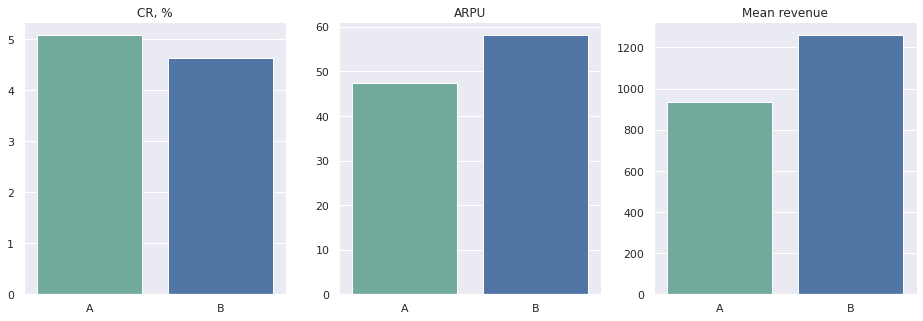

In [97]:
draw_plots(metrics_df)

# Task 2. SQL
___
###  Task

**2.1.Condition**

Educational courses consist of various lessons, each of which includes several small tasks. Each small task is called a "pea."

A student is considered "very diligent" if they have correctly solved at least 20 peas at least once during the current month.

**2.2. Task**

Given the table default.peas:

| Attribute Name	 | Attribute Type	 | Meaning |
|-------------------|--------------|--------------------|
| st_id             | int          | Student ID        |
| timest            | timestamp    | Time of task completion |
| correct           | bool         | Correctness of task  (True/False) |
| subject           | text         | Subject in which the pea is located |


You need to write an optimal query that provides information about the number of very diligent students. NB! A diligent student is defined as one who has correctly solved 20 tasks in the current month.

In [3]:
import pandahouse as ph

In [4]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [123]:
query = """
SELECT 
    COUNT(DISTINCT st_id) AS active_students

FROM (
    SELECT st_id, 
    COUNT(subject) AS number_sub
    FROM default.peas 
    WHERE correct = 1
    GROUP BY st_id
    HAVING number_sub >= 20
    )
"""
df_1 = ph.read_clickhouse(query, connection=connection_default)
df_1

,active_students
0,136


**2.2 Funnel Optimization**

**2.2.1 Condition**

The educational platform offers courses to students on a trial basis: a student can solve up to 30 peas per day for free. To access an unlimited number of tasks in a given subject, the student needs to purchase full access. The team conducted an experiment where a new payment screen was tested.

**2.2.2 Task**

Given the tables: default.peas (as described above), default.studs:

| Attribute Name | Attribute Type | Meaning |
|-------------------|--------------|--------------------|
| st_id             | int          | Student ID        |
| test_grp          | text         | Student label in the experiment |


и default.final_project_check:

| Attribute Name | Attribute Type | Meaning |
|-------------------|--------------|--------------------|
| st_id             | int          | Student ID         |
| sale_time         | timestamp    | Time of purchase      |
| money           | int         | Price at which the course was purchased |
| subject           | text         | Subject in which the pea is located |


You need to output the following information about user groups in a single query:

- **ARPU** (Average Revenue Per User)
- **ARPAU** (Average Revenue Per Active User)
- **CR to purchase**
- **CR of active users to purchase **
- **CR of users active in math (subject = 'math') to purchase a math course**

ARPU is calculated relative to all users in the groups.
An active user is defined as one who has correctly solved more than 10 tasks in any subject.
An active user in math is defined as one who has correctly solved 2 or more tasks in math.

In [6]:
query = """
SELECT 
    a.test_grp AS test_group,
    sum(c.Revenue) / count(DISTINCT a.st_id) AS ARPU,
    sum(c.Revenue) / countIf(b.count_of_peas > 9) AS ARPAU,
    sum(c.count_of_purchases)/count(a.st_id) *100 AS CR,
    sum(c.count_of_purchases) / countIf(b.count_of_peas > 10) *100 AS CR_active_user_to_buy,
    sum(c.count_math_purchases) / countIf(b.sum_correct_Math > 1) *100 AS math_CR
FROM
    default.studs AS a
LEFT JOIN
    (SELECT
        st_id,
        sum(correct) AS count_of_peas,
        sumIf(correct, subject=='Math') AS sum_correct_Math
    FROM 
        default.peas
    GROUP BY
        st_id
    ) AS b
ON a.st_id = b.st_id
LEFT JOIN 
    (SELECT 
        st_id,
        sum(money) AS Revenue,
        uniqExactIf(st_id, money>0) AS count_of_purchases,
        uniqExactIf(st_id, subject=='Math') AS count_math_purchases
    FROM
        default.final_project_check
    GROUP BY 
        st_id
    ) AS c
ON 
    b.st_id = c.st_id
GROUP BY 
    a.test_grp
"""
df_2 = ph.read_clickhouse(query, connection=connection_default).round(2)
df_2

,test_group,ARPU,ARPAU,CR,CR_active_user_to_buy,math_CR
0,control,4540.98,10492.42,4.92,11.81,16.33
1,pilot,11067.80,32326.73,10.17,31.25,38.10
